# Segmentation des clients d'une grande surface

Le but de ce notebook est d'essayer de trouver et afficher le bon nombre de clusters au sein de la clientelle d'un super marché.

## Méthodologie

- Analyse descriptive
- Déterminer le nombre de clusters avec la méthode dite du "coude" ([Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)))
- Afficher ces clusters avec leurs centroïds

## Sources

Les données sont accessibles sur [Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

sns.set_theme(style='darkgrid')
sns.set_context("paper")

In [2]:
# Importe les données

df = pd.read_csv('data/mall_customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# Renommage des colonnes
columns = ['CustomerID', 'Gender', 'Age', 'AnnualIncome', 'SpendingScore']
df.columns = columns
# Male = 0, Female = 1
new_gender = {
    'Male': 0,
    'Female': 1
}
df['Gender'].replace(new_gender, inplace=True)
df.head()

,CustomerID,Gender,Age,AnnualIncome,SpendingScore
0,1,0,19,15,39
1,2,0,21,15,81
2,3,1,20,16,6
3,4,1,23,16,77
4,5,1,31,17,40


In [4]:
# Aucune donnée manquante
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   CustomerID     200 non-null    int64
 1   Gender         200 non-null    int64
 2   Age            200 non-null    int64
 3   AnnualIncome   200 non-null    int64
 4   SpendingScore  200 non-null    int64
dtypes: int64(5)
memory usage: 7.9 KB


In [5]:
df.isna().sum()

CustomerID       0
Gender           0
Age              0
AnnualIncome     0
SpendingScore    0
dtype: int64

In [6]:
df.describe()
# Hummm, intéressant...
# Essayons plutôt de visualiser les données !

,CustomerID,Gender,Age,AnnualIncome,SpendingScore
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,0.560000,38.850000,60.560000,50.200000
std,57.879185,0.497633,13.969007,26.264721,25.823522
min,1.000000,0.000000,18.000000,15.000000,1.000000
25%,50.750000,0.000000,28.750000,41.500000,34.750000
50%,100.500000,1.000000,36.000000,61.500000,50.000000
75%,150.250000,1.000000,49.000000,78.000000,73.000000
max,200.000000,1.000000,70.000000,137.000000,99.000000


# Annual Income vs Spending Score
On remarque avec le graphique ci-dessous une certaine segmentation en fonction des revenus annuels: on peut en dénombrer 5.  
Avec l'ajout d'un graphique de type *contour*, on remarque que certaibns ont un poids plus important que d'autres:
- Central, visant la catégorie de revenus entre 40-60k$
- A droite, avec des revenus hauts similaires et une importance non négligeable et un socre opposé
- A gauche, avec des revenus faibles et une importance moins significative et un score opposé

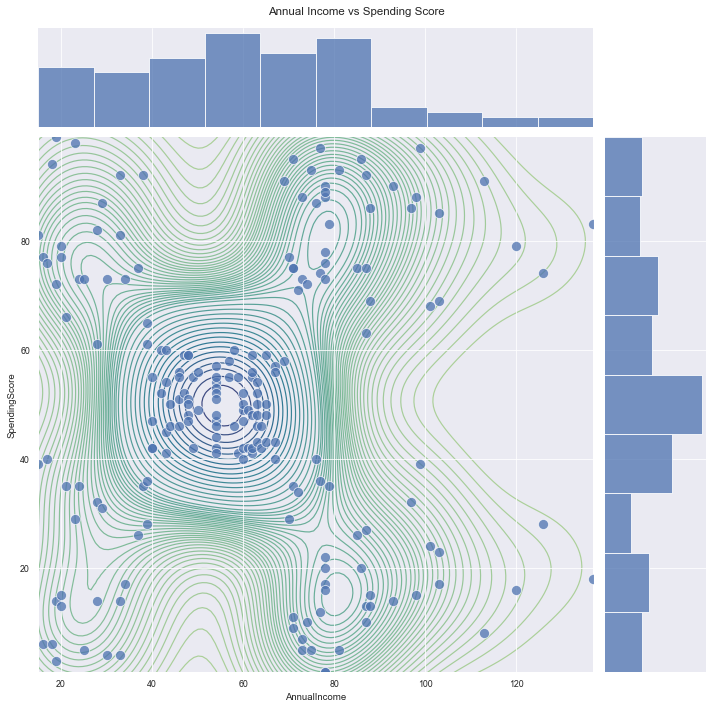

In [7]:
g = (
    # Scatter selon x y avec des histogrammes en marge
    sns.jointplot(x="AnnualIncome", y="SpendingScore", data=df, kind="scatter", s=100, alpha=.75)
    # Et ajoute un kdeplot de type contour à 50 levels
    .plot_joint(sns.kdeplot, zorder=0, n_levels=50, cmap='crest', alpha=.9)
)
# Définit l'étendue des axes
_ = g.ax_marg_y.set_ylim([df.SpendingScore.min(), df.SpendingScore.max()])
_ = g.ax_marg_x.set_xlim([df.AnnualIncome.min(), df.AnnualIncome.max()])
# Taille du graphique
_ = g.fig.set_size_inches([10, 10])

_ = g.fig.suptitle("Annual Income vs Spending Score")
_ = g.fig.tight_layout()
_ = g.fig.subplots_adjust(top=0.95)

plt.show()


# Age vs Spending Score
On remarque avec le graphique ci-dessous une certaine segmentation en fonction de l'âge des client.  
Avec l'ajout d'un graphique de type *contour*, on remarque que deux sont prépondérants:
- La classe d'âge des 30 ans semble être la plus importante en terme de population et de score d'achat
- La classe d'âge entre 45 et 50 apparaît elle aussi significative en population mais avec un score d'achat moyen (~50)

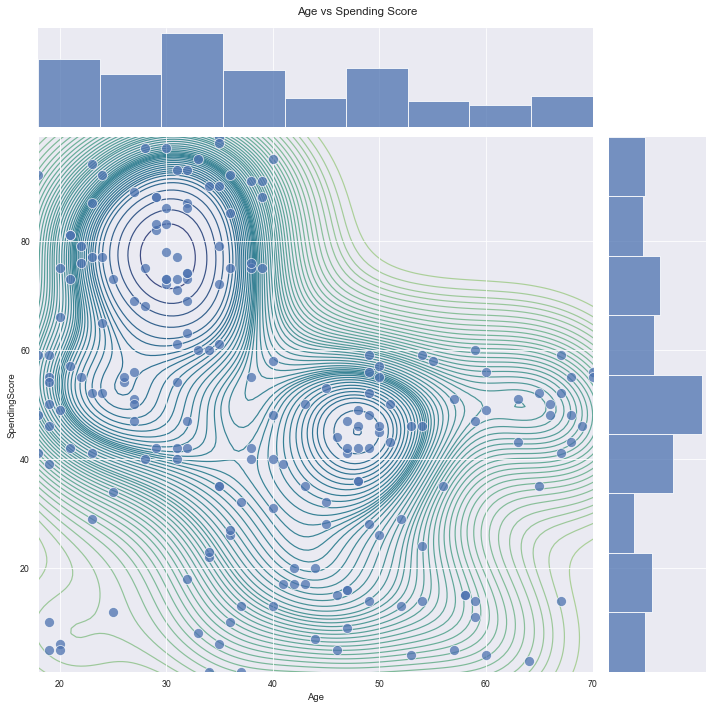

In [8]:
g = (
    sns.jointplot(x="Age", y="SpendingScore", data=df, kind="scatter", s=100, alpha=.75)
    .plot_joint(sns.kdeplot, zorder=0, n_levels=50, cmap='crest', alpha=.9)
)

_ = g.ax_marg_y.set_ylim([df.SpendingScore.min(), df.SpendingScore.max()])
_ = g.ax_marg_x.set_xlim([df.Age.min(), df.Age.max()])

_ = g.fig.set_size_inches([10, 10])

_ = g.fig.suptitle("Age vs Spending Score")
_ = g.fig.tight_layout()
_ = g.fig.subplots_adjust(top=0.95)

plt.show()

## Age vs Annual Income

Essayons de distinguer des groupes selon ces deux variables.

On peut voir que n'est pas évident de dicerner des clusters aussi facilement avec ces deux variables.

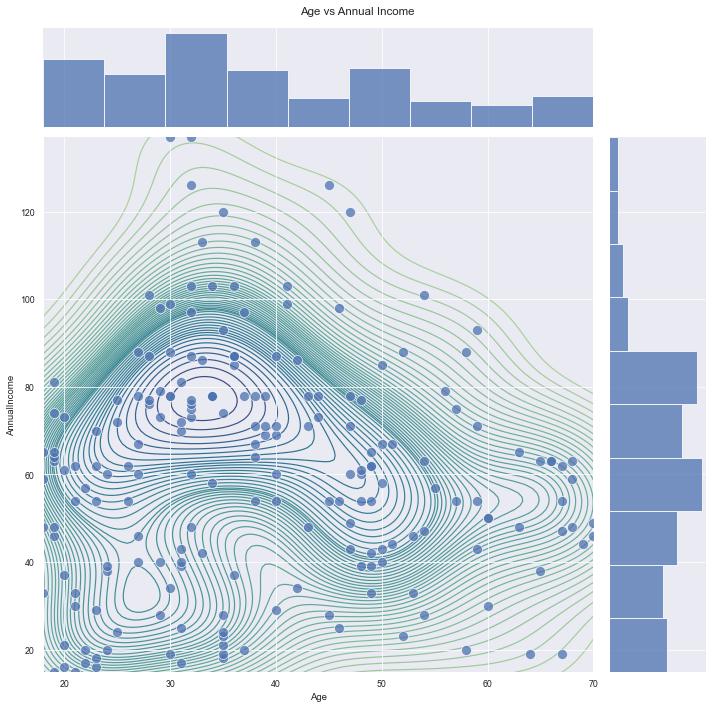

In [9]:
g = (
    sns.jointplot(x="Age", y="AnnualIncome", data=df, kind="scatter", s=100, alpha=.75)
    .plot_joint(sns.kdeplot, zorder=0, n_levels=50, cmap='crest', alpha=.9)
)

_ = g.ax_marg_y.set_ylim([df.AnnualIncome.min(), df.AnnualIncome.max()])
_ = g.ax_marg_x.set_xlim([df.Age.min(), df.Age.max()])

_ = g.fig.set_size_inches([10, 10])

_ = g.fig.suptitle("Age vs Annual Income")
_ = g.fig.tight_layout()
_ = g.fig.subplots_adjust(top=0.95)

plt.show()

## Kmeans

Essayons de trouver des clusters dans nos données.

### Clusters Annual Income vs Spending Score
Nous avons vu plus haut qu'il est aisé de distinguer des clusters selon ces deux dimensions. Je ne vais pas implémenter Kmeans avec celles-ci.

### Clusters Age vs SpendingScore
La visualisation, ici, est un peu moins claire, c'est pourquoi il est intéressant de tester l'algorythme Kmeans.

- Elbow method: permet de trouver le nombre de cluster adéquat
- Entrainement de Kmeans avec le bon nombre
- Affichge des clusters avec leurs centroïdes

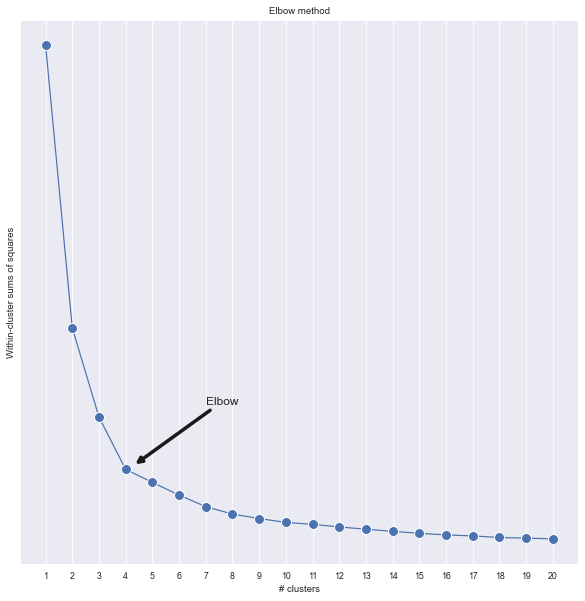

In [10]:
X = df[['Age', 'SpendingScore']].values
wcss=[]

for i in range(1,21):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize=(10, 10))

_ = ax.plot(range(1,21), wcss, 'o-', ms=10, mec='w', mew='1')

_ = ax.annotate("Elbow", xy=(4.3, 29500), xytext=(7, 50000), size=12,
                arrowprops = dict(
                    arrowstyle= '-|>',
                    lw=3.5,
                    color='k',
                    ls='-') )

_ = plt.title('Elbow method')

_ = plt.xlabel('# clusters')
_ = plt.ylabel('Within-cluster sums of squares')
_ = plt.xticks(range(1, 21))
_ = plt.yticks([])

plt.show()

In [11]:
# Entrainement !
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
y_kmeans= kmeans.fit_predict(X)


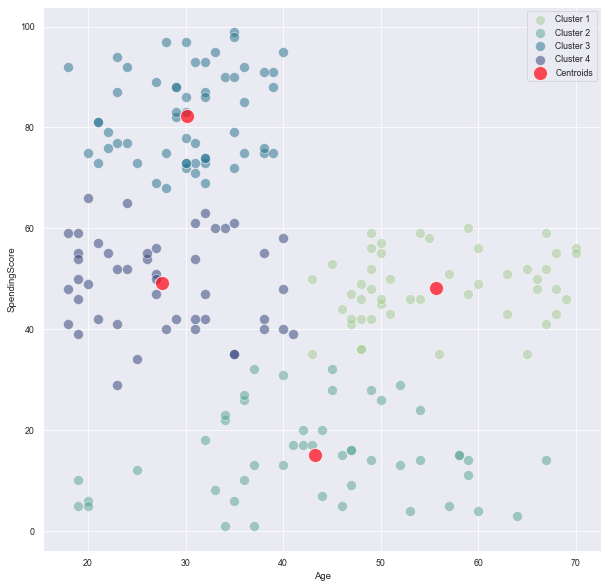

In [12]:
import warnings
warnings.filterwarnings("ignore")

# 4 couleurs
c = ['#a1cb90', '#55a28f', '#1e6e8a', '#2a3975']
# Init. le graph 10x10
_ = plt.figure(figsize=(10, 10))
# For pour éviter de se répéter
for i in range(0, 4):
    # Affiche chaque clusters
    _ = sns.scatterplot(X[y_kmeans == i, 0], X[y_kmeans == i, 1], color=c[i], label ='Cluster {}'.format(i+1), s=100, alpha=.5)
# Affiche les centroïdes
_ = sns.scatterplot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, label='Centroids', color='#FF0011', alpha=.7)
# Labels
_ = plt.xlabel('Age')
_ = plt.ylabel('SpendingScore')
# Show
plt.show()

### Interprétations

On remarque assez bien nos 4 clusters et ceux-ci semblent faire sens.

### Clusters Age vs Annual Income

Même process que précédemment.

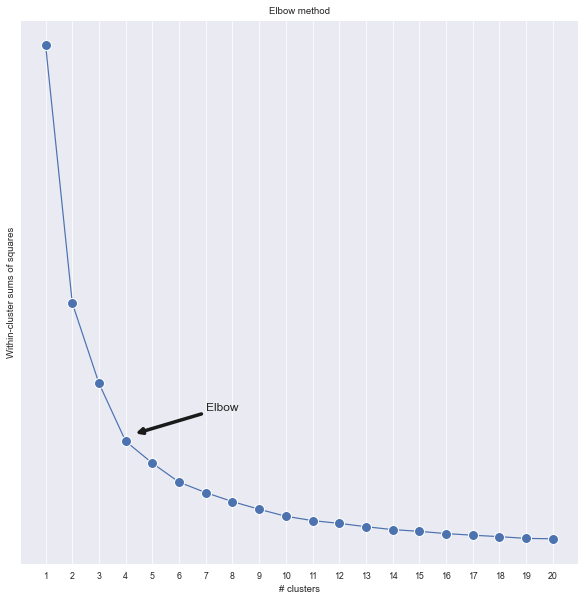

In [17]:
X = df[['Age', 'AnnualIncome']].values
wcss=[]

for i in range(1,21):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize=(10, 10))

_ = ax.plot(range(1,21), wcss, 'o-', ms=10, mec='w', mew='1')

_ = ax.annotate("Elbow", xy=(4.3, 42000), xytext=(7, 50000), size=12,
                arrowprops = dict(
                    arrowstyle= '-|>',
                    lw=3.5,
                    color='k',
                    ls='-') )

_ = plt.title('Elbow method')

_ = plt.xlabel('# clusters')
_ = plt.ylabel('Within-cluster sums of squares')
_ = plt.xticks(range(1, 21))
_ = plt.yticks([])

plt.show()

In [18]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
y_kmeans= kmeans.fit_predict(X)

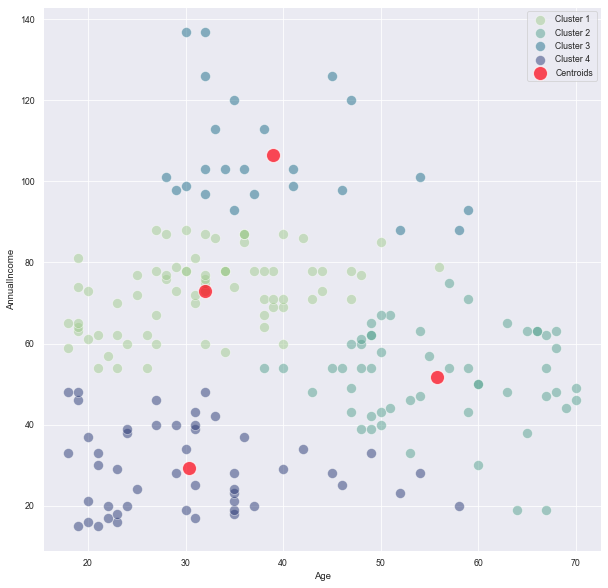

In [19]:
c = ['#a1cb90', '#55a28f', '#1e6e8a', '#2a3975']

_ = plt.figure(figsize=(10, 10))
for i in range(0, 4):
    _ = sns.scatterplot(X[y_kmeans == i, 0], X[y_kmeans == i, 1], color=c[i], label ='Cluster {}'.format(i+1), s=100, alpha=.5)
_ = sns.scatterplot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, label='Centroids', color='#FF0011', alpha=.7)

_ = plt.xlabel('Age')
_ = plt.ylabel('AnnualIncome')

plt.show()